# Monte Carlo Simulation

## Initial Code setup

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

POLICY_CURRENT = 'current'
POLICY_PROPOSED = 'proposed'
POLICY_INVALID = 'Invalid Policy'
REPLACEMENTS_VALUE = 45
SEED_VALUE = 42

# consistent colors for all charts
COLORS_DICT = {
    "Fans": "steelblue",
    "Labor": "darkorange",
    "Downtime": "green"
}
COLORS_SIM_DICT = ["royalblue", "firebrick"]  # distinct policy colors

# Fan life distribution, refers to 'Table1_FanLife' sheet
fan_life_values = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900] #in hours
fan_life_probabilities  = [0.10, 0.13, 0.25, 0.13, 0.09, 0.12, 0.02, 0.06, 0.05, 0.05]

# Technician arrival distribution, refers to 'Table2_TechArrival' sheet
technician_arrival_times = [20, 30, 45] #in minutes
technician_arrival_time_probabilities  = [0.60, 0.30, 0.10]

# Costs, refers to 'Table3_costs' sheet
fan_cost = 32
server_downtime_cost_per_min = 10
labor_cost_per_hr = 30

# Replacement times (minutes), refers to 'Replacement_Time' sheet
# format is { 'number of fans replace' : 'time in minutes'}
replacement_times = {1: 20, 2: 30, 3: 40}


## Functions Declarations

### Sampling function

In [252]:
def sample_fan_life():
    return np.random.choice(fan_life_values, p=fan_life_probabilities)

def sample_tech_arrival():
    return np.random.choice(technician_arrival_times, p=technician_arrival_time_probabilities)

In [253]:
NUM_RUNS = 500   # adjustable
# Allows to record multiple simulations for the monte carlo theory 
# Helps simulate multiple runs to reduce standard deviation and create more reliable results.
# ================================================================
# SIMULATION FUNCTIONS
# ================================================================
def simulate_policy_aggregated(policy=POLICY_CURRENT, total_replacements=REPLACEMENTS_VALUE, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Initialize 3 fan slots, each with random lifetime
    fan_slots = [sample_fan_life() for _ in range(3)]

    rows = []
    fans_replaced = 0
    cummulative_downtime = 0
    cummulative_cost = 0
    elapsed_time_hours = 0

    cummulative_fan_cost = 0
    cummulative_labor_cost = 0
    cummulative_downtime_cost = 0

    while fans_replaced < total_replacements:
        failure_time = min(fan_slots)
        elapsed_time_hours += failure_time

        # Reduce all slots
        fan_slots = [t - failure_time for t in fan_slots]

        # Identify failures
        failed_indices = [i for i, t in enumerate(fan_slots) if t <= 0]
        num_failed = len(failed_indices)

        if policy == POLICY_CURRENT:
            num_replaced = num_failed
            for idx in failed_indices:
                fan_slots[idx] = sample_fan_life()
        elif policy == POLICY_PROPOSED:
            num_replaced = 3
            fan_slots = [sample_fan_life() for _ in range(3)]
        else:
            raise ValueError(POLICY_INVALID)

        num_replaced = min(num_replaced, total_replacements - fans_replaced)
        fans_replaced += num_replaced

        # Downtime
        maint_time = replacement_times.get(num_replaced, 40)
        tech_delay = sample_tech_arrival()
        downtime_min = tech_delay + maint_time
        downtime_hr = downtime_min / 60.0

        # Costs
        fan_cost_total = num_replaced * fan_cost
        downtime_cost = downtime_min * server_downtime_cost_per_min
        labor_cost_total = (maint_time / 60) * labor_cost_per_hr
        total_cost = fan_cost_total + downtime_cost + labor_cost_total

        # Cumulative updates
        cummulative_downtime += downtime_hr
        cummulative_cost += total_cost
        cummulative_fan_cost += fan_cost_total
        cummulative_labor_cost += labor_cost_total
        cummulative_downtime_cost += downtime_cost

        rows.append({
            "Failure Time (hrs)": round(failure_time, 2),
            "Fans Replaced": num_replaced,
            "Total Fans Replaced": fans_replaced,
            "Random Tech Arrival (min)": tech_delay,
            "Maintenance Time (min)": maint_time,
            "Down time (hrs)": round(downtime_hr, 2),
            "Cumulative downtime": round(cummulative_downtime, 2),
            "Fan Cost": fan_cost_total,
            "Total Fan Cost": cummulative_fan_cost,
            "Labor Cost": round(labor_cost_total, 2),
            "Total Labor Cost": round(cummulative_labor_cost, 2),
            "Downtime Cost": downtime_cost,
            "Total Downtime Cost": cummulative_downtime_cost,
            "Total Cost": round(total_cost, 2),
            "Cumulative Total Cost": round(cummulative_cost, 2),
            "Time (hr*100)": round(elapsed_time_hours * 100, 0)
        })

    return pd.DataFrame(rows)


def run_multiple_simulations(policy, num_runs=100, total_replacements=REPLACEMENTS_VALUE, seed=None):
    """
    Original version — keeps only the final row of each run (summary).
    """
    results = []

    for i in range(num_runs):
        sim_seed = None if seed is None else seed + i
        df = simulate_policy_aggregated(policy, total_replacements=total_replacements, seed=sim_seed)
        final_row = df.iloc[-1]
        results.append({
            "Run": i + 1,
            "Cumulative Total Cost": final_row["Cumulative Total Cost"],
            "Total Fan Cost": final_row["Total Fan Cost"],
            "Total Labor Cost": final_row["Total Labor Cost"],
            "Total Downtime Cost": final_row["Total Downtime Cost"],
            "Cumulative downtime": final_row["Cumulative downtime"],
            "Total Fans Replaced": final_row["Total Fans Replaced"],
            "Time (hr*100)": final_row["Time (hr*100)"]
        })

    return pd.DataFrame(results)


def run_multiple_simulations_all(policy, num_runs=100, total_replacements=REPLACEMENTS_VALUE, seed=None):
    """
    New version — keeps all rows of all runs (for plotting).
    """
    all_runs = []

    for i in range(num_runs):
        sim_seed = None if seed is None else seed + i
        df = simulate_policy_aggregated(policy, total_replacements=total_replacements, seed=sim_seed)
        df["Run"] = i + 1
        all_runs.append(df)

    return pd.concat(all_runs, ignore_index=True)

def build_results_aggregated(df_sim_v1, df_sim_v2, formatted=True):
    """
    Compare Simulation V1 vs Simulation V2 using aggregated multi-run results.
    """
    results = pd.DataFrame({
        "Simulation": ["Simulation V1", "Simulation V2"],
        "Mean Total Cost": [
            df_sim_v1["Cumulative Total Cost"].mean(),
            df_sim_v2["Cumulative Total Cost"].mean()
        ],
        "Std Total Cost": [
            df_sim_v1["Cumulative Total Cost"].std(),
            df_sim_v2["Cumulative Total Cost"].std()
        ],
        "Mean Fan Cost": [
            df_sim_v1["Total Fan Cost"].mean(),
            df_sim_v2["Total Fan Cost"].mean()
        ],
        "Mean Labor Cost": [
            df_sim_v1["Total Labor Cost"].mean(),
            df_sim_v2["Total Labor Cost"].mean()
        ],
        "Mean Downtime Cost": [
            df_sim_v1["Total Downtime Cost"].mean(),
            df_sim_v2["Total Downtime Cost"].mean()
        ],
        "Mean Downtime (hrs)": [
            df_sim_v1["Cumulative downtime"].mean(),
            df_sim_v2["Cumulative downtime"].mean()
        ],
        "Mean Fans Replaced": [
            df_sim_v1["Total Fans Replaced"].mean(),
            df_sim_v2["Total Fans Replaced"].mean()
        ],
        "Mean Time (hrs)": [
            (df_sim_v1["Time (hr*100)"]/100).mean(),
            (df_sim_v2["Time (hr*100)"]/100).mean()
        ],
        "Mean Days Equivalent": [
            ((df_sim_v1["Time (hr*100)"]/100)/24).mean(),
            ((df_sim_v2["Time (hr*100)"]/100)/24).mean()
        ],
        "Mean Cost / Time": [
            (df_sim_v1["Cumulative Total Cost"] / (df_sim_v1["Time (hr*100)"]/100)).mean(),
            (df_sim_v2["Cumulative Total Cost"] / (df_sim_v2["Time (hr*100)"]/100)).mean()
        ]
    })

    if formatted:
        results_fmt = results.copy()
        for col in results.columns:
            if "Cost" in col:
                results_fmt[col] = results_fmt[col].map("${:,.2f}".format)
            elif "Hours" in col or "Days" in col:
                results_fmt[col] = results_fmt[col].map("{:,.2f}".format)
            elif "Mean" in col or "Std" in col:
                results_fmt[col] = results_fmt[col].map("{:,.2f}".format)
        return results, results_fmt

    return results



## Running Simulations

In [254]:
# ================================================================
# RUN SIMULATIONS
# ================================================================

print("Running simulations")
print("iteration count:", NUM_RUNS)

# Run simulations ONCE and keep all rows
df_all_current = run_multiple_simulations_all(POLICY_CURRENT, num_runs=NUM_RUNS, total_replacements=REPLACEMENTS_VALUE, seed=SEED_VALUE)
df_all_proposed = run_multiple_simulations_all(POLICY_PROPOSED, num_runs=NUM_RUNS, total_replacements=REPLACEMENTS_VALUE, seed=SEED_VALUE)

# Summary is located at the last row only
# Extract last row per run for summary
agg_current = df_all_current.groupby("Run").tail(1).reset_index(drop=True)
agg_proposed = df_all_proposed.groupby("Run").tail(1).reset_index(drop=True)

agg_numeric, agg_summary = build_results_aggregated(agg_current, agg_proposed, formatted=True)
print(agg_summary)

Running simulations
iteration count: 500
      Simulation Mean Total Cost Std Total Cost Mean Fan Cost Mean Labor Cost  \
0  Simulation V1      $21,107.88        $884.63     $1,440.00         $432.78   
1  Simulation V2      $11,562.60        $294.52     $1,440.00         $300.00   

  Mean Downtime Cost Mean Downtime (hrs) Mean Fans Replaced Mean Time (hrs)  \
0         $19,235.10               32.06              45.00       20,476.00   
1          $9,822.60               16.37              45.00       17,142.20   

  Mean Days Equivalent Mean Cost / Time  
0               853.17            $1.03  
1               714.26            $0.67  


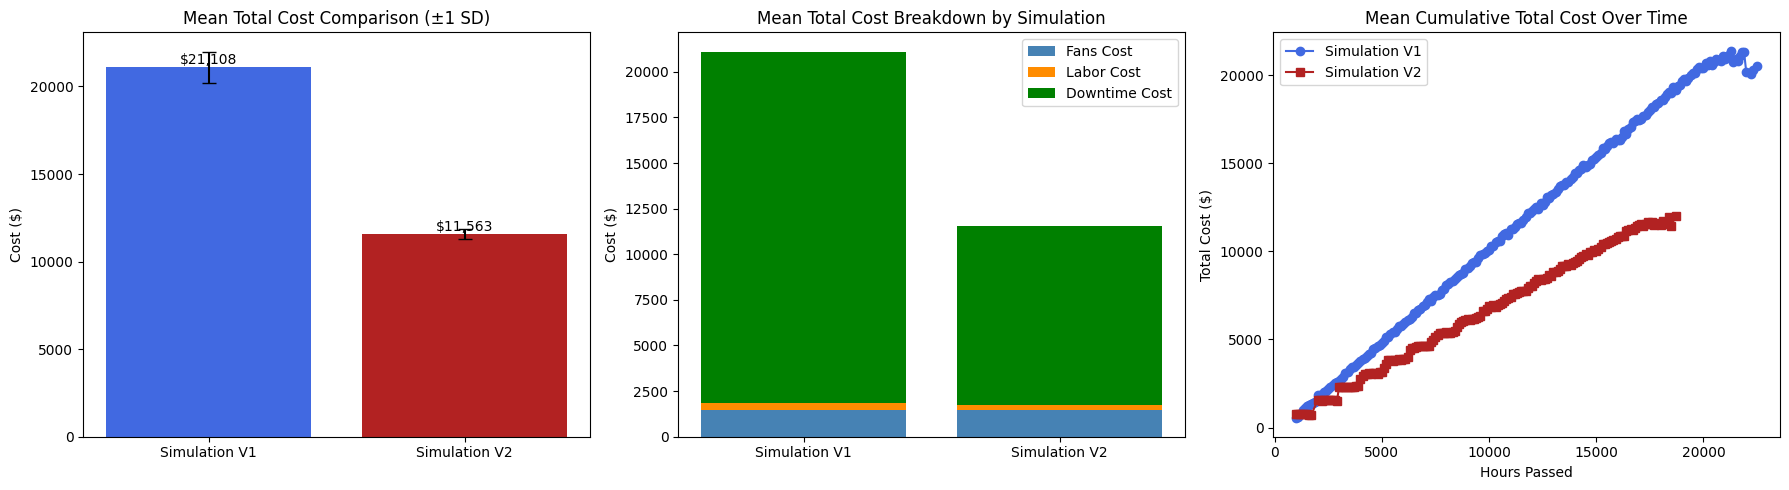

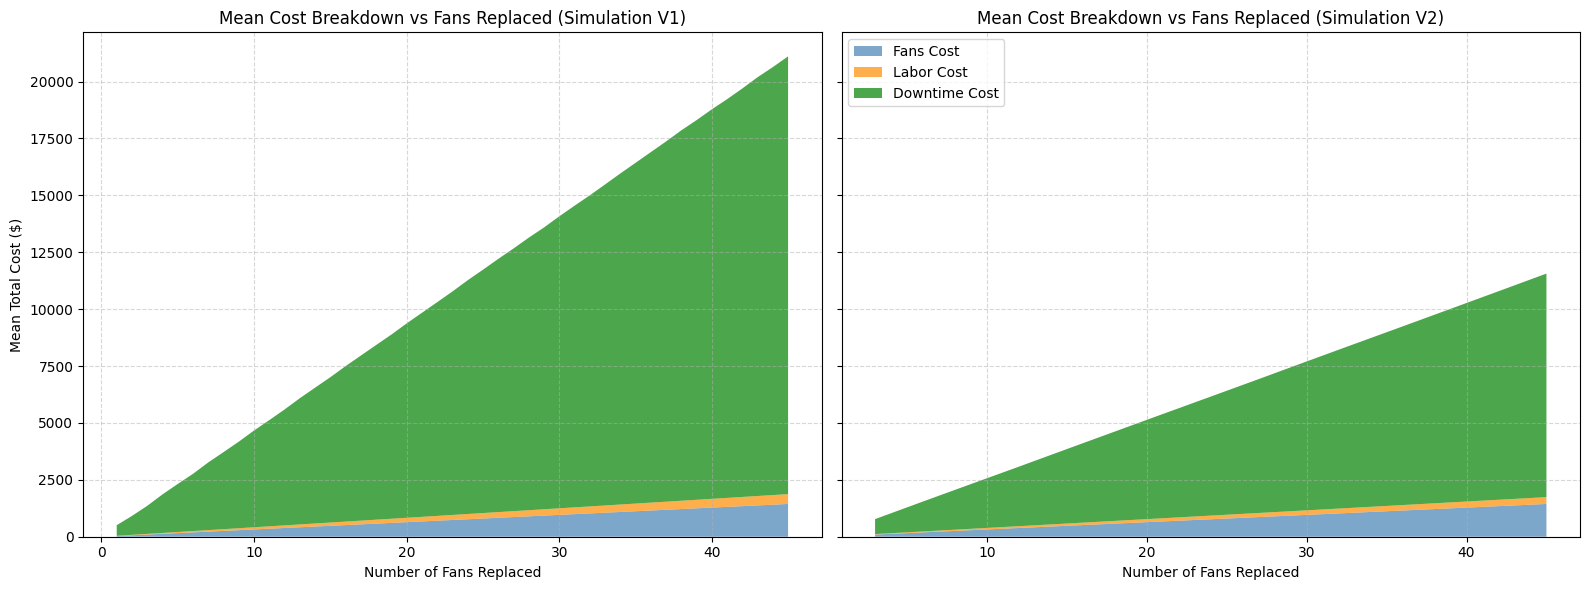

,Simulation,Mean Total Cost,Std Total Cost,Mean Fan Cost,Mean Labor Cost,Mean Downtime Cost,Mean Downtime (hrs),Mean Fans Replaced,Mean Time (hrs),Mean Days Equivalent,Mean Cost / Time
0,Simulation V1,"$21,107.88",$884.63,"$1,440.00",$432.78,"$19,235.10",32.06,45.00,"20,476.00",853.17,$1.03
1,Simulation V2,"$11,562.60",$294.52,"$1,440.00",$300.00,"$9,822.60",16.37,45.00,"17,142.20",714.26,$0.67


In [255]:

# ================================================================
# 1. RESULTS DASHBOARD (1x3)
# ================================================================
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# --- 1. Total Cost Comparison ---
mean_costs = [agg_current["Cumulative Total Cost"].mean(),
              agg_proposed["Cumulative Total Cost"].mean()]
std_costs  = [agg_current["Cumulative Total Cost"].std(),
              agg_proposed["Cumulative Total Cost"].std()]

bars = axes[0].bar(["Simulation V1", "Simulation V2"], mean_costs,
                   yerr=std_costs, capsize=5, color=COLORS_SIM_DICT)
axes[0].set_title("Mean Total Cost Comparison (±1 SD)")
axes[0].set_ylabel("Cost ($)")
for bar, val in zip(bars, mean_costs):
    axes[0].text(bar.get_x() + bar.get_width()/2, val, f"${val:,.0f}", 
                 ha="center", va="bottom")

# --- 2. Cost Breakdown by Simulation (Stacked Bar of Totals) ---
p = np.arange(2)
bars1 = axes[1].bar(p,
    [agg_current["Total Fan Cost"].mean(), agg_proposed["Total Fan Cost"].mean()],
    label="Fans Cost", color=COLORS_DICT["Fans"])
bars2 = axes[1].bar(p,
    [agg_current["Total Labor Cost"].mean(), agg_proposed["Total Labor Cost"].mean()],
    bottom=[agg_current["Total Fan Cost"].mean(), agg_proposed["Total Fan Cost"].mean()],
    label="Labor Cost", color=COLORS_DICT["Labor"])
bars3 = axes[1].bar(p,
    [agg_current["Total Downtime Cost"].mean(), agg_proposed["Total Downtime Cost"].mean()],
    bottom=[agg_current["Total Fan Cost"].mean() + agg_current["Total Labor Cost"].mean(),
            agg_proposed["Total Fan Cost"].mean() + agg_proposed["Total Labor Cost"].mean()],
    label="Downtime Cost", color=COLORS_DICT["Downtime"])

axes[1].set_xticks(p)
axes[1].set_xticklabels(["Simulation V1", "Simulation V2"])
axes[1].set_title("Mean Total Cost Breakdown by Simulation")
axes[1].set_ylabel("Cost ($)")
axes[1].legend()

# --- 3. Mean Cumulative Total Cost Over Time ---
mean_curve_current = df_all_current.groupby("Time (hr*100)")["Cumulative Total Cost"].mean()
mean_curve_proposed = df_all_proposed.groupby("Time (hr*100)")["Cumulative Total Cost"].mean()

axes[2].plot(mean_curve_current.index/100, mean_curve_current.values,
             label="Simulation V1", color=COLORS_SIM_DICT[0], marker="o")
axes[2].plot(mean_curve_proposed.index/100, mean_curve_proposed.values,
             label="Simulation V2", color=COLORS_SIM_DICT[1], marker="s")
axes[2].set_title("Mean Cumulative Total Cost Over Time")
axes[2].set_xlabel("Hours Passed")
axes[2].set_ylabel("Total Cost ($)")
axes[2].legend()

plt.tight_layout()
plt.show()


# ================================================================
# 2. COST BREAKDOWN STACKPLOTS (Totals vs Fans Replaced)
# ================================================================
mean_current = df_all_current.groupby("Total Fans Replaced")[["Total Fan Cost","Total Labor Cost","Total Downtime Cost"]].mean()
mean_proposed = df_all_proposed.groupby("Total Fans Replaced")[["Total Fan Cost","Total Labor Cost","Total Downtime Cost"]].mean()

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# --- Left: Simulation V1 (Current) ---
axes[0].stackplot(
    mean_current.index,
    mean_current["Total Fan Cost"],
    mean_current["Total Labor Cost"],
    mean_current["Total Downtime Cost"],
    labels=["Fans Cost", "Labor Cost", "Downtime Cost"],
    colors=[COLORS_DICT["Fans"], COLORS_DICT["Labor"], COLORS_DICT["Downtime"]],
    alpha=0.7
)
axes[0].set_title("Mean Cost Breakdown vs Fans Replaced (Simulation V1)")
axes[0].set_xlabel("Number of Fans Replaced")
axes[0].set_ylabel("Mean Total Cost ($)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Right: Simulation V2 (Proposed) ---
axes[1].stackplot(
    mean_proposed.index,
    mean_proposed["Total Fan Cost"],
    mean_proposed["Total Labor Cost"],
    mean_proposed["Total Downtime Cost"],
    labels=["Fans Cost", "Labor Cost", "Downtime Cost"],
    colors=[COLORS_DICT["Fans"], COLORS_DICT["Labor"], COLORS_DICT["Downtime"]],
    alpha=0.7
)
axes[1].set_title("Mean Cost Breakdown vs Fans Replaced (Simulation V2)")
axes[1].set_xlabel("Number of Fans Replaced")
axes[1].grid(True, linestyle="--", alpha=0.5)

axes[1].legend(loc="upper left")

plt.tight_layout()
plt.show()
agg_summary

   Num Runs    Policy  Mean Total Cost  Std Total Cost
0        10   Current         21102.50     1097.712900
1        10  Proposed         11565.00      351.386144
2        50   Current         21024.10      948.092979
3        50  Proposed         11555.00      266.735748
4       200   Current         21122.75      890.441107
5       200  Proposed         11563.50      292.447221
6       500   Current         21107.88      884.633630
7       500  Proposed         11562.60      294.521180


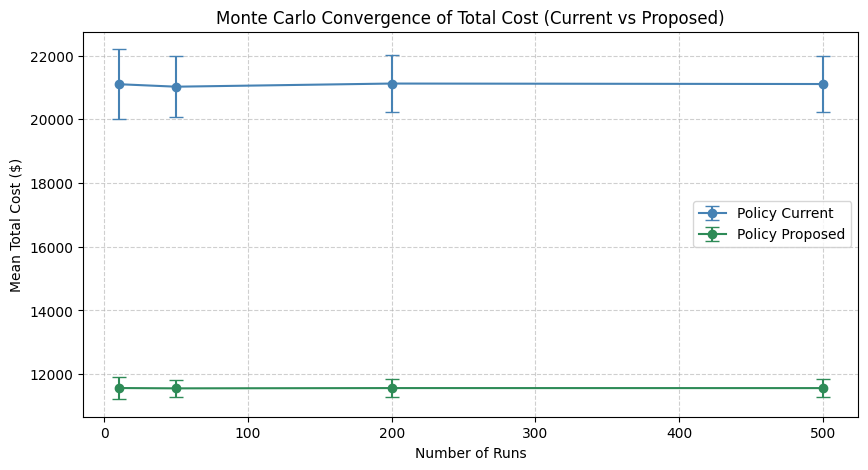

In [257]:
# ================================================================
# MONTE CARLO CONVERGENCE EXPERIMENT (Both Policies)
# ================================================================
test_runs = [10, 50, 200, 500]  # different num_runs settings
summary_data = []

for n in test_runs:
    # Current policy
    df_all_current = run_multiple_simulations_all(POLICY_CURRENT, num_runs=n, total_replacements=REPLACEMENTS_VALUE, seed=SEED_VALUE)
    agg_current = df_all_current.groupby("Run").tail(1).reset_index(drop=True)
    
    # Proposed policy
    df_all_proposed = run_multiple_simulations_all(POLICY_PROPOSED, num_runs=n, total_replacements=REPLACEMENTS_VALUE, seed=SEED_VALUE)
    agg_proposed = df_all_proposed.groupby("Run").tail(1).reset_index(drop=True)
    
    # Record results
    summary_data.append({
        "Num Runs": n,
        "Policy": "Current",
        "Mean Total Cost": agg_current["Cumulative Total Cost"].mean(),
        "Std Total Cost": agg_current["Cumulative Total Cost"].std()
    })
    summary_data.append({
        "Num Runs": n,
        "Policy": "Proposed",
        "Mean Total Cost": agg_proposed["Cumulative Total Cost"].mean(),
        "Std Total Cost": agg_proposed["Cumulative Total Cost"].std()
    })

df_convergence_both = pd.DataFrame(summary_data)

# Print results
print(df_convergence_both)

# ================================================================
# Plot
# ================================================================
plt.figure(figsize=(10,5))

for policy, color in zip(["Current", "Proposed"], ["steelblue", "seagreen"]):
    subset = df_convergence_both[df_convergence_both["Policy"] == policy]
    plt.errorbar(subset["Num Runs"], subset["Mean Total Cost"],
                 yerr=subset["Std Total Cost"], fmt="o-", capsize=5,
                 color=color, label=f"Policy {policy}")

plt.title("Monte Carlo Convergence of Total Cost (Current vs Proposed)")
plt.xlabel("Number of Runs")
plt.ylabel("Mean Total Cost ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


<h2>Experiment Results</h2>
<ul>
    <li>
        <p> Monte Carlo experiment shows as the number of runs increases, the mean total cost stabilizes and the standard deviation decreases, this demonstrates <b><i>convergence</i></b>. </p>
    </li>
    <li>
        <p>
        Across all sample sizes, the proposed <b><i>replacement policy (Simulation v2)</i></b> consistently yields lower costs compared to the <b><i>current policy (Simulation v1)</i></b>. </p>
    </li>
</ul>
<h3>This observations above validates experiment is effectivene. </h3>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cms/hospital-general-information")

print("Path to dataset files:", path)

In [1]:
pip install kagglehub


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/fritz/venvs/jupyter-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files saved to: /Users/fritz/Library/CloudStorage/OneDrive-GUSCanada/PROGRESS/2025-3rd term - Summer Term/【WED】2-DAMO-600-6-Prescriptive-Analytics/assignment2/2025-09-04
